<a href="https://colab.research.google.com/github/ComposerY/2048-bot/blob/master/DeepQ_trader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DQ Trader

Sharp eyes noticed that in my previous blog  ['Teaching a Robot to Buy Low and Sell High'](https://medium.com/@gjlr2000/teaching-a-robot-to-buy-low-sell-high-c8d4f061b93d) there was no mention of neural networks.

Yet, in all the news the talk is all about how 'deep learning' was used to beat humans in their own turf (Go). So where can the neural networks be used ?

In a nutshell: instead of building a gigantic 'cheatsheet' (please read my above blog) built by simulating tons of possible 'states', we train a neural network.

What follows is quite geeky, so feel free to skip it.

## Substituting the Q-space with  a Q-space function

Neural networks prefer data to be within a limited range (usually from 0 to 1 or -1 to 1), so in the code I will scale Ritter's parameters:


In [0]:
import matplotlib.pyplot as plt


import random
import numpy as np
import pandas as pd
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam


def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]



class PSpaceRitter:
    def __init__(self, 
                 H = 5, 
                 P_e = 50, 
                 sigma = 0.1, 
                 P_min = 0.1, 
                 P_max = 100, 
                 tick_size = 0.1,
                 lot_size = 100):
        self.theta = np.log(2) / H
        self.P_maxOrg = P_max
        self.P_minOrg = P_min
        self.P_eOrg = P_e
        # P_spaceOrg => Unscaled Price Space
        self.P_spaceOrg = np.arange(0,(P_max-P_min)/tick_size+1)*tick_size + np.round(P_min/tick_size)*tick_size
        self.Pdiv = (self.P_maxOrg - self.P_minOrg) / 2.0
        # Scale the resuting prices to fit a range from -1 to 1
        self.P_space = (self.P_spaceOrg - P_e)/ self.Pdiv        
        self.sigma = sigma
        self.TickSizeOrg = tick_size        
        self.P_e = self.P_eOrg - P_e
        self.TickSize = (self.P_space[1] - self.P_space[0])
        self.LotSize = lot_size

                
    def PriceOrg(self, d):
        return find_nearest(self.P_spaceOrg, d)

    def Price(self, d):
        return find_nearest(self.P_space, d)
  
    def PriceSamplerOrg(self, sampleSize):
        eps_t = np.random.randn(sampleSize)
        pe = self.P_eOrg
        sigma = self.sigma
        lambda_ = self.theta
        p = self.PriceOrg(pe)

        prices = [p]
        for i in range(0,sampleSize):
            y = np.log(p / pe)
            y = y + sigma * eps_t[i] - lambda_ * y
            pnew = pe * np.exp(y)
            # pnew = np.min([pnew, self.P_max])
            # discretizing to make sure it appear in P_space
            prices.append(self.PriceOrg(pnew))
            # this one seems missing !
            p = pnew
        return prices
    
    def PriceSampler(self, sampleSize):
        prices = self.PriceSamplerOrg(sampleSize)
        return ((pd.DataFrame(prices) - self.P_eOrg) / self.Pdiv).values

    def SpreadCost(self, d_n):
        return self.TickSize * np.abs(d_n)
    
    def ImpactCost(self, d_n, LotSizeScl):
        return d_n * d_n*self.TickSize/ LotSizeScl
    


Once we have a model of the price movement, we can add the full space by selecting how many actions we want to consider at any point (2*K +1) and a maximum level of the portfolio (M)

In [0]:
class PHASpace:
    def __init__(self, pSpace,
                  M = 10, 
                  K = 5):


        self.Pdiv = pSpace.Pdiv
        self.P_e = pSpace.Pdiv
        self.P_space = pSpace.P_space
        self.P_spaceOrg = pSpace.P_spaceOrg
        self.pSpace = pSpace       
        self.A_spaceOrg = np.arange(-K ,K+1)*pSpace.LotSize
        self.H_spaceOrg = np.arange(-M, M+1)*pSpace.LotSize
        self.Hdiv = M * pSpace.LotSize
        self.TickSize = (self.P_space[1] - self.P_space[0])

        self.A_space = self.A_spaceOrg / self.Hdiv
        self.H_space = self.H_spaceOrg / self.Hdiv
        
        self.LotSize = pSpace.LotSize / self.Hdiv

        self.iterables = [ self.P_space, self.H_space ]
        self.State_space = pd.MultiIndex.from_product(self.iterables)    
        self.Q_space = pd.DataFrame(index = self.State_space, columns = self.A_space).fillna(0)

        self.iterablesOrg = [ self.P_spaceOrg, self.H_spaceOrg ]
        self.State_spaceOrg = pd.MultiIndex.from_product(self.iterablesOrg)    
        self.Q_spaceOrg = pd.DataFrame(index = self.State_spaceOrg, columns = self.A_spaceOrg).fillna(0)
    

    def Holding(self ,d):
        return find_nearest(self.H_space, d)
      
    def PriceSampler(self, N_train):
        return self.pSpace.PriceSampler(N_train)

    def Price(self, dn):
        return self.pSpace.Price(dn)
           
    def HoldingOrg(self ,d):
        return find_nearest(self.H_spaceOrg, d)
      
    def PriceSamplerOrg(self, N_train):
        return self.pSpace.PriceSamplerOrg(N_train)

    def PriceOrg(self, dn):
        return self.pSpace.PriceOrg(dn)

In pure Q-trading we simulated the process thousands of times to fill the table. In my previous blog you will see how some cells remain unfilled or filled with only a few random numbers. 

The resulting policy could give a very high Sharpe ratio, but a human he could barely make sense out of it as sometimes the computer would tell him to buy high when the price is already high (just because it there was one time when the simulation went even higher at that particular state).

For every price and holding there is a vector of 11 elements (11 actions: from going short from -K to being long K lots).  We could try to fit a curve instead of filling up the 231 cells of the table,.

**Note** I will be using neural networks below just because they are in vogue, but you can actually use any other function approximator. Neural networks are [universal approximators](https://en.wikipedia.org/wiki/Universal_approximation_theorem), but so are humble [polynomial functions](https://en.wikipedia.org/wiki/Stone%E2%80%93Weierstrass_theorem).

I will replace the 'cheatsheet filling' of the Q-space with a neural network represented by:


```
model = Sequential()      
model.add(Dense(self.action_size*2, input_dim=self.state_size, activation='hard_sigmoid'))
model.add(Dense(self.action_size*2, activation='hard_sigmoid'))
model.add(Dense(self.action_size, activation='linear'))
model.compile(loss='mse',
            optimizer=Adam(lr=self.learning_rate))

```

The state has two variables (price and holding), and there are 11 possible action, so the neural network is a:

*   2 inputs (price and holding)
*   a layer of 11 x 2 = 22  'sigmoid' neurons,
* another layer of 22 'sigmoid' neurons
* a layer of 11 'linear' neurons

**Note** we could change to another 'universal approximator' - make life easier with polynomial, but as this is a didactic blog I keep with the latest hype.







Below I redefine functions I need; 

In [0]:


class DQNAgent:
    def __init__(self,
                 phaSp, 
                 batch_size = 1000, 
                 gamma = 0.999, 
                 epsilon = 0.1, 
                 epsilon_min = 0.01, 
                 epsilon_decay = 1, 
                 learning_rate = 0.001, 
                 kappa = 0.0001, 
                 N_train = 10000, 
                 ):

        self.phaSp = phaSp
        
        self.state_example = (self.phaSp.Price(0), self.phaSp.Holding(0))
        self.state_size = len(self.state_example)
        self.action_size = len(self.phaSp.A_space)
        self.batch_size = batch_size

        self.memory = deque(maxlen=self.batch_size*100)
        self.gamma = gamma    # discount rate
        self.epsilon = epsilon  # exploration rate
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate
        self.alpha = self.learning_rate
        self.kappa = kappa
        self.N_train = N_train
        self.TickSize = phaSp.TickSize  
        self.LotSize = phaSp.LotSize         
        self.model = self._build_model()
    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()      
        # Attempt one 
        #model.add(Dense(24, input_dim=self.state_size, activation='sigmoid'))
        #model.add(Dense(24, activation='sigmoid'))
        # Or dynamic architecture
        model.add(Dense(self.action_size*2, input_dim=self.state_size, activation='hard_sigmoid'))
        model.add(Dense(self.action_size*2, activation='hard_sigmoid'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse',
                      optimizer=Adam(lr=self.learning_rate))
        return model
    def remember(self, state, action, reward, next_state):
        self.memory.append((state, action, reward, next_state))
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # returns action
    def train(self, state, action, reward, next_state):
        target = reward + self.gamma * \
                   np.amax(self.model.predict(next_state)[0])
        target_f = self.model.predict(state)
        target_f[0][action] = target
        self.model.fit(state, target_f, epochs=1, verbose=0)
    def save(self, name):
        self.model.save_weights(name)
    def load(self, name):
        self.model.load_weights(name)
        
        
    def SpreadCost(self, d_n):
        return self.TickSize * np.abs(d_n)
    #    return 0.0

    def ImpactCost(self, d_n):
        return d_n * d_n*self.TickSize/self.LotSize
    #    return 0.0

    def TotalCost(self, d_n):
        return self.phaSp.pSpace.SpreadCost(d_n) + self.phaSp.pSpace.ImpactCost(d_n, self.LotSize)


    def ResultReward(self, currState, nextState):
        currPrice = currState[0]
        nextPrice = nextState[0]
        currHolding = currState[1]
        nextHolding = nextState[1]
        dn = nextHolding - currHolding
        cost = self.TotalCost(dn)
        pricedif = nextPrice - currPrice
        pnl = nextHolding * pricedif - cost
        reward = pnl -0.5 * self.kappa * (pnl * pnl)
        result = {
                'pnl': pnl,
                'cost': cost,
                'reward' : reward,
                'dn' : dn
                }
        return result
    
    
    def LearningSimple(self, N_train) :
        pricePath = self.phaSp.PriceSampler(N_train)
 
        currState = (self.phaSp.Price(self.phaSp.P_e), self.phaSp.Holding(0))
        for e in range(0, N_train-1):
            state = np.reshape(currState, [1, self.state_size])
            action = self.act(state)
            shares_traded = self.phaSp.A_space[action]
            currHolding = currState[1]
            nextHolding = self.phaSp.Holding(currHolding + shares_traded)
            nextPrice = pricePath[e+1]
            nextState = (nextPrice, nextHolding)
            next_state = np.reshape(nextState, [1, self.state_size])
            result = self.ResultReward(currState, nextState)
            reward = result['reward']
            self.train(state, action, reward, next_state)
            state = next_state
            currState = nextState
            #if e % 1000 == 0:
            #    print(e)
            #    print(currState, reward)

            
    def OutOfSample(self, nsteps):
        pricePath = self.phaSp.PriceSampler(nsteps+1)
        currHolding = self.phaSp.Holding(0)
        pnl = []

        for i in range(0, nsteps):

            currPrice = pricePath[i]
            currState = (currPrice, currHolding)
            state = np.reshape(currState, [1, self.state_size])
            action = self.act(state)
            shares_traded = self.phaSp.A_space[action]
            #shares_traded = chooseAction(currState)

            nextHolding = self.phaSp.Holding(currHolding + shares_traded)

            nextPrice = pricePath[i+1]
            nextState = (nextPrice, nextHolding)

            result = self.ResultReward(currState, nextState)
            #pnl.append(result['pnl'])
            pnl.append(result['pnl'] * self.phaSp.Pdiv * self.phaSp.Hdiv)

            currHolding = nextHolding

        return pd.DataFrame(pnl)


      
      
    def mapQspace(self):
        
        aa = self.phaSp.Q_space.reset_index()
        bb = self.model.predict(aa[['level_0', 'level_1']].values)
        cc = self.phaSp.Q_spaceOrg.copy()
 
        cc.iloc[:,:] = bb
        return cc



The code above now will do all the work. 

So now I create an 'agent' that uses the full Q-space generated when the price dynamics behave as Ritter -- 

**Note** you can now add another class that generates different dynamics, *but* the deep Q trader will only work if the space follows a Markov Decision Process -- so if you were to add a Geometric Brownian Motion the deep Q trader does not work.

In [0]:

pRit = PSpaceRitter()
ps = PHASpace(pRit)

agent = DQNAgent(ps)


## DQN-Trader explained

DQN-Trader: [D]eep [Q]-space [N]eural Network.

Instead of filling up the Q-space cheatsheet, we fit/train the NN with the rewards. That's it.


How does it work ? Let's see:

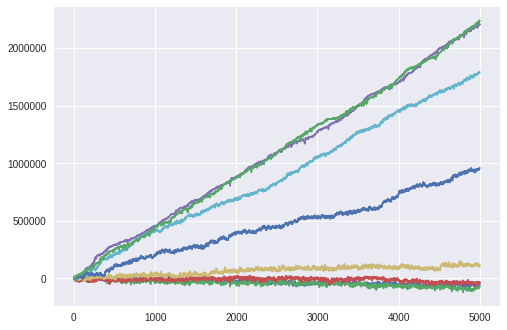

In [0]:
pnl = agent.OutOfSample(5000)
plt.plot(pnl.cumsum())

for i in range(0,7):
  agent.LearningSimple(10000)
  pnl = agent.OutOfSample(5000)
  plt.plot(pnl.cumsum())
plt.show()
from google.colab import files

modelWeightsName = 'dqn_trader.h5'
agent.model.save_weights(modelWeightsName)
files.download(modelWeightsName)    


On my experiments, I just needed to run about 70k training examples (as opposed to  the 10 million simulations to fill the Q-space cheatsheet) to get the same performance as in [Machine Learning for Trading](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3015609).

However, I believe the main advantage is the visibility of the result - in my previous blog [Teaching a Robot to 'Buy Low' and 'Sell High'](https://medium.com/@gjlr2000/teaching-a-robot-to-buy-low-sell-high-c8d4f061b93d) the Action cheatsheet was very noisy.

But look at the neural-network cheatsheet:

It is very clear (in red) that a trader has to sell whenever price is above 50, and even lower *if* there is already a holding of the asset. The regions seems to be partitioned in nice lines.

To be fair, the lines could be derived analytically (as we have the underlying model), but this does show that a neural network can be used to derive a 'white-box' intuitive action cheatsheet.

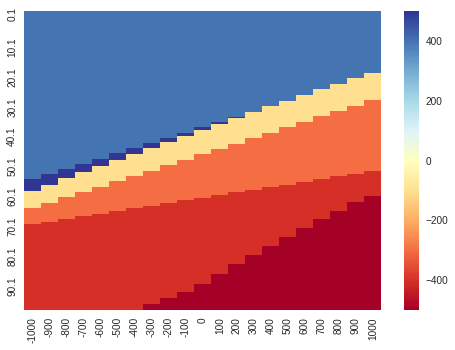

In [0]:
DQ_space = agent.mapQspace()
DQ_full_action = (pd.DataFrame(DQ_space.idxmax(axis =1))).unstack()

import seaborn as sns
from matplotlib.ticker import FormatStrFormatter

ax = sns.heatmap(DQ_full_action[0], yticklabels=100, cmap = 'RdYlBu')

majorFormatter = FormatStrFormatter('%0.2f')
plt.show()

A different perspective (3D)

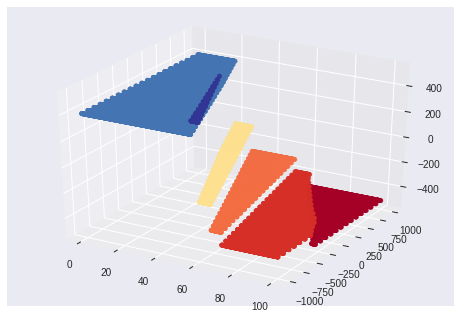

In [0]:
Q_action = (pd.DataFrame(DQ_space.idxmax(axis =1))).reset_index()
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.gca(projection='3d')
Qcols = Q_action.columns
X = Q_action[Qcols[0]].values
Y = Q_action[Qcols[1]].values
Z = Q_action[Qcols[2]].values
ax.scatter3D(X, Y, Z, c=Z, cmap = 'RdYlBu');